### Datasets

* BPIC15 (as in the forest paper)
    * Case-related// `caseStatus`, `SUMleges`, `last_phase`, `parts`
    * Activity-related// `phase` (derived from `action_code`)
    * Time-related// (time componets extracted from original timestamps)

* BPIC17 (as in OrdinoR paper)
    * Case-related// `LoanGoal`, `ApplicationType`, `RequestedAmount`, `OfferedAmount`
    * Activity-related// `EventOrigin`, `Action`
    * Time-related// (time componets extracted from original timestamps)


In [1]:
import pandas as pd

# Preprocess data

DATASET = 'bpic17'

if DATASET == 'bpic15':
    # BPIC15
    fn = 'data/raw/bpic15.csv'
    df = pd.read_csv(fn)[[
        'Case ID', 'Activity', 'Resource',
        '(case) caseStatus','(case) SUMleges', '(case) last_phase', '(case) parts',
        'action_code',
        'Complete Timestamp',
    ]]
    df = df.rename(columns={
        '(case) caseStatus': 'ct//case_status',
        '(case) SUMleges': 'ct//sum_leges',
        '(case) last_phase': 'ct//last_phase',
    })
    
    # BPIC15-specific// use only data from the main subprocess (01HOOFD)
    df = df[~df['action_code'].isna()]
    df = df[df['action_code'].str.startswith('01_HOOFD')]
    
    # Preprocess to derive new attributes
    # 'ct//permit_type' from `(case) parts`, as an example of user-supplied categorization rules
    df = df[~df['(case) parts'].isna()]
    df['ct//permit_type'] = df.apply(lambda row: 'Bouw' if 'Bouw' in str(row['(case) parts']).split(',') else 'Non Bouw', axis=1)
    # `at//phase` from `action_code`, as an example of user-supplied categorization rules
    df = df[~df['action_code'].isna()]
    df['at//phase'] = df['action_code'].apply(lambda code: code[:10])
    
    df = df.drop(columns=['(case) parts', 'action_code'])
    
    # TODO// Handle missing data
    
    

if DATASET == 'bpic17':
    # BPIC17
    fn = 'data/raw/bpic17.csv'
    df = pd.read_csv(fn)[[
        'Case ID', 'Activity', 'Resource',
        'LoanGoal', 'ApplicationType', 'RequestedAmount', 'OfferedAmount',
        'EventOrigin', 'Action',
        'Complete Timestamp',
    ]]
    df = df.rename(columns={
        'LoanGoal': 'ct//loan_goal',
        'ApplicationType': 'ct//application_type',
        'RequestedAmount': 'ct//requested_amount',
        'OfferedAmount': 'ct//offered_amount',
        'EventOrigin': 'at//event_origin',
        'Action': 'at//action',
    })
    
    # TODO// Handle missing data

# Universal (on Disco outputs)// time components (month, day, weekday, ampm) extracted from complete timestamps
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['tt//month'] = df['Complete Timestamp'].apply(lambda ts: MONTHS[ts.month-1])
df['tt//day'] = df['Complete Timestamp'].apply(lambda ts: 'Day_{}'.format(ts.day))
WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['tt//weekday'] = df['Complete Timestamp'].apply(lambda ts: WEEKDAYS[ts.dayofweek])
df['tt//ampm'] = df['Complete Timestamp'].apply(lambda ts: 'AM' if ts.hour < 12 else 'PM')

### LightBGM

* Here we test the "impurty-only" variant of our method (Step 2 Learn Composite Rules)
* We adopt LightGBM, which is a relatively recent variant of decision tree learning (2017)
* It is a boosting method (hence we let `n_estimator=1` to "simulate" a single decision tree)
* It claims to outperform methods in the literature
* It adopts the best-first tree expansion strategy
* It has Python-based implementation and supports splitting on categorical and numerical attributes

In [2]:
import lightgbm as lgb

print(f'Number of events in the log is {len(df)}')
y = df['Resource']
print(f'Number of resources in the log is {len(set(y))}')

if DATASET == 'bpic15':
    pred = [
        'ct//case_status', 'ct//sum_leges', 'ct//last_phase', 'ct//permit_type',
        'at//phase',
        'tt//month', 'tt//day', 'tt//weekday', 'tt//ampm'
    ]
    cat_cols = ['ct//case_status', 'ct//last_phase', 'ct//permit_type', 'at//phase', 'tt//month', 'tt//day', 'tt//weekday', 'tt//ampm']
    df[cat_cols] = df[cat_cols].astype('category')

if DATASET == 'bpic17':
    pred = [
        'ct//loan_goal', 'ct//application_type', 'ct//requested_amount', 'ct//offered_amount',
        'at//event_origin', 'at//action',
        'tt//month', 'tt//day', 'tt//weekday', 'tt//ampm'
    ]
    cat_cols = ['ct//loan_goal', 'ct//application_type', 'at//event_origin', 'at//action', 'tt//month', 'tt//day', 'tt//weekday', 'tt//ampm']
    df[cat_cols] = df[cat_cols].astype('category')
    
#print(df)

clf = lgb.LGBMClassifier(n_estimators=1)
clf.fit(df[pred], y, feature_name=pred, categorical_feature=cat_cols)

Number of events in the log is 475306
Number of resources in the log is 144


/home/yjingasd/miniconda3/envs/orgmining/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(n_estimators=1)

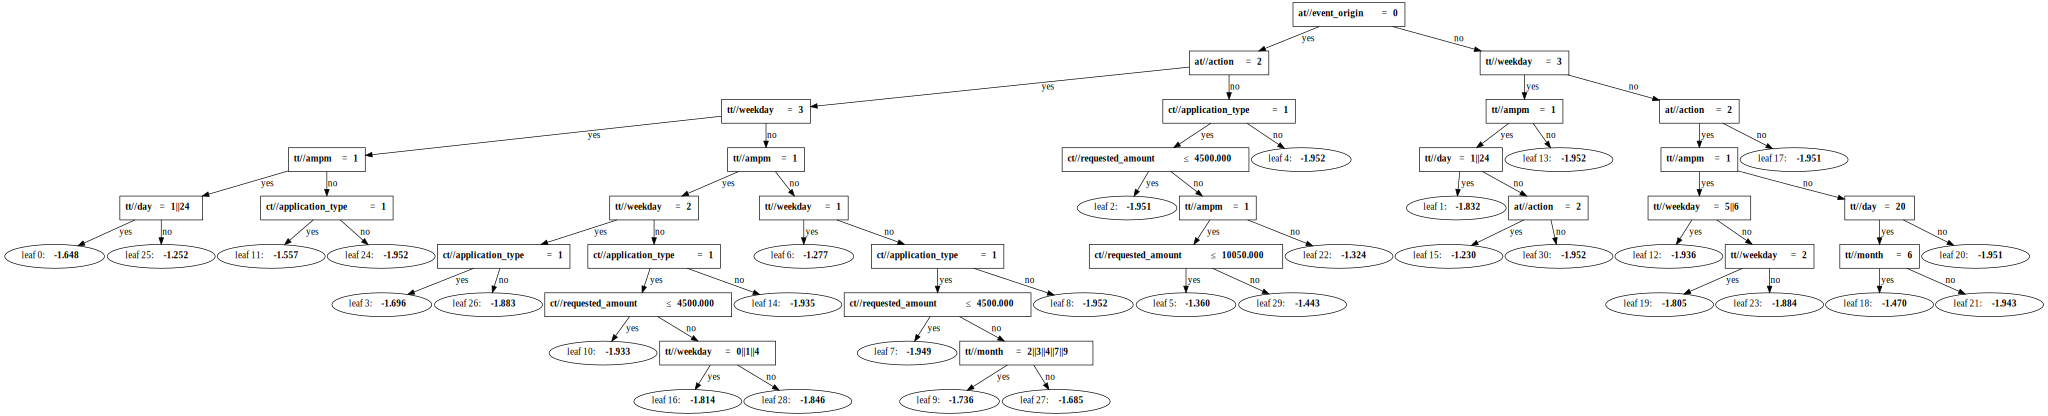

In [3]:
import matplotlib.pyplot as plt
lgb.create_tree_digraph(clf, orientation='vertical')

In [4]:
# access leaf nodes

#print(clf.booster_.num_trees())

tree = clf.booster_.trees_to_dataframe()

leaves = tree[(tree['tree_index'] == 0) & tree['left_child'].isnull() & tree['right_child'].isnull()]
print(f"The tree covers {leaves['count'].sum()} events in {len(leaves)} leaf nodes")
print(leaves)

The tree covers 475306 events in 31 leaf nodes
    tree_index  node_depth node_index left_child right_child parent_index  \
5            0           6       0-L0       None        None        0-S24   
6            0           6      0-L25       None        None        0-S24   
8            0           6      0-L11       None        None        0-S23   
9            0           6      0-L24       None        None        0-S23   
13           0           7       0-L3       None        None        0-S25   
14           0           7      0-L26       None        None        0-S25   
17           0           8      0-L10       None        None        0-S15   
19           0           9      0-L16       None        None        0-S27   
20           0           9      0-L28       None        None        0-S27   
21           0           7      0-L14       None        None        0-S13   
23           0           6       0-L6       None        None         0-S6   
26           0           8   

In [7]:
# extract rules

# `parent_index`
def get_paths(df_tree, leaves):
    paths = []
    for leaf in leaves:
        path = [leaf]
        while True:
            parent_index = df_tree.loc[df_tree['node_index'] == path[0], 'parent_index'].iloc[0]
            if parent_index is None:
                print(f'Path from leaf "{leaf}" to root node: {path}')
                paths.append(path)
                break
            else:
                path = [parent_index] + path
    return paths

paths = get_paths(tree, set(leaves['node_index']))
assert len(paths) == len(leaves)

print('-' * 20)

# `split_feature`
# `decision_type`
# `threshold`
def extract_rules(df_tree, paths):
    for path in paths:
        ct = []
        at = []
        tt = []
        for i in range(len(path) - 1):
            node_index = path[i]
            row = df_tree.loc[df_tree['node_index'] == node_index]
            split_feature = row['split_feature'].iloc[0]
            decision_type = row['decision_type'].iloc[0]
            threshold = row['threshold'].iloc[0]
            # TODO: map threshold back to actual value, if split_feature is categorical
            if split_feature in cat_cols:
                cat_vals = list(df[split_feature].cat.categories)
                if '||' not in threshold:
                    threshold = cat_vals[int(threshold)]
                else:
                    threshold = threshold.replace('||', ' OR ')
                    threshold = f'({threshold})'
            
            if split_feature.startswith('ct'):
                ct.append(f'{split_feature} {decision_type} {threshold}')
            if split_feature.startswith('at'):
                at.append(f'{split_feature} {decision_type} {threshold}')
            if split_feature.startswith('tt'):
                tt.append(f'{split_feature} {decision_type} {threshold}')
        print(f'CT:{" AND ".join(ct) if len(ct) > 0 else "null"}')
        print(f'AT:{" AND ".join(at) if len(at) > 0 else "null"}')
        print(f'TT:{" AND ".join(tt) if len(tt) > 0 else "null"}')
        print('-' * 20)

extract_rules(tree, paths)

Path from leaf "0-L21" to root node: ['0-S0', '0-S11', '0-S16', '0-S17', '0-S19', '0-S20', '0-L21']
Path from leaf "0-L4" to root node: ['0-S0', '0-S1', '0-S3', '0-L4']
Path from leaf "0-L28" to root node: ['0-S0', '0-S1', '0-S2', '0-S5', '0-S9', '0-S13', '0-S15', '0-S27', '0-L28']
Path from leaf "0-L2" to root node: ['0-S0', '0-S1', '0-S3', '0-S4', '0-L2']
Path from leaf "0-L16" to root node: ['0-S0', '0-S1', '0-S2', '0-S5', '0-S9', '0-S13', '0-S15', '0-S27', '0-L16']
Path from leaf "0-L25" to root node: ['0-S0', '0-S1', '0-S2', '0-S10', '0-S24', '0-L25']
Path from leaf "0-L5" to root node: ['0-S0', '0-S1', '0-S3', '0-S4', '0-S21', '0-S28', '0-L5']
Path from leaf "0-L14" to root node: ['0-S0', '0-S1', '0-S2', '0-S5', '0-S9', '0-S13', '0-L14']
Path from leaf "0-L20" to root node: ['0-S0', '0-S11', '0-S16', '0-S17', '0-S19', '0-L20']
Path from leaf "0-L17" to root node: ['0-S0', '0-S11', '0-S16', '0-L17']
Path from leaf "0-L24" to root node: ['0-S0', '0-S1', '0-S2', '0-S10', '0-S23', '0